## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units, num_neurons, ch):
    input_layer = keras.layers.Input(input_shape)
    if ch == 1:
        x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if ch == 1:
                x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            else:
                x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            if ch == 2:
                x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, activation="relu")(x)
            if ch == 3:
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            if ch == 2:
                x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, activation="relu")(x)
            if ch == 3:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [2, 16, 32, 128, 256, 1024]
MOMENTUM = 0.95

In [7]:
def Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, output_units, num_neurons, ch, results):
    for size in BATCH_SIZE:
        model = build_mlp(x_train.shape[1:], output_units, num_neurons, ch)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train,
                  epochs=EPOCHS, 
                  batch_size= size, # 不同 Batch_size比較 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "Batch_Size %s" % str(size)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(results, ch):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    
    sNB = ""
    if ch == 0:
        sNB = "No BN layer "
    elif ch == 1:
        sNB = "BN after Input Layer "
    elif ch == 2:
        sNB = "BN before Activation "
    else:
        sNB = "BN after Activation "
    
    plt.title(sNB + "Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title(sNB + "Accuracy")
    plt.legend()
    plt.show()

In [9]:
output_units = 10
num_neurons = [64, 32, 16]

# BN after Activation
results_3 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, output_units, num_neurons, 3, results_3)

W0718 23:11:07.131236 19396 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 23:11:07.143203 19396 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 23:11:07.145197 19396 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 23:11:07.203073 19396 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 23:11:07.359162 19396 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
__________

50000/50000 [==============================] - 8s 162us/step - loss: 1.5613 - acc: 0.4459 - val_loss: 1.5681 - val_acc: 0.4439
Epoch 14/20
50000/50000 [==============================] - 8s 158us/step - loss: 1.5476 - acc: 0.4495 - val_loss: 1.5387 - val_acc: 0.4515
Epoch 15/20
50000/50000 [==============================] - 8s 159us/step - loss: 1.5430 - acc: 0.4519 - val_loss: 1.5391 - val_acc: 0.4579
Epoch 16/20
50000/50000 [==============================] - 8s 157us/step - loss: 1.5467 - acc: 0.4490 - val_loss: 1.6486 - val_acc: 0.4124
Epoch 17/20
50000/50000 [==============================] - 8s 156us/step - loss: 1.5388 - acc: 0.4501 - val_loss: 1.5662 - val_acc: 0.4345
Epoch 18/20
50000/50000 [==============================] - 8s 159us/step - loss: 1.5286 - acc: 0.4559 - val_loss: 1.5404 - val_acc: 0.4535
Epoch 19/20
50000/50000 [==============================] - 8s 159us/step - loss: 1.5246 - acc: 0.4598 - val_loss: 1.5570 - val_acc: 0.4466
Epoch 20/20
50000/50000 [==============

Epoch 6/20
50000/50000 [==============================] - 3s 53us/step - loss: 1.5560 - acc: 0.4448 - val_loss: 1.5727 - val_acc: 0.4356
Epoch 7/20
50000/50000 [==============================] - 3s 53us/step - loss: 1.5324 - acc: 0.4536 - val_loss: 1.6075 - val_acc: 0.4265
Epoch 8/20
50000/50000 [==============================] - 3s 53us/step - loss: 1.5070 - acc: 0.4607 - val_loss: 1.7317 - val_acc: 0.3985
Epoch 9/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.4850 - acc: 0.4701 - val_loss: 1.6163 - val_acc: 0.4214
Epoch 10/20
50000/50000 [==============================] - 3s 63us/step - loss: 1.4643 - acc: 0.4749 - val_loss: 1.5625 - val_acc: 0.4418
Epoch 11/20
50000/50000 [==============================] - 3s 70us/step - loss: 1.4458 - acc: 0.4847 - val_loss: 1.5666 - val_acc: 0.4359
Epoch 12/20
50000/50000 [==============================] - 3s 68us/step - loss: 1.4325 - acc: 0.4886 - val_loss: 1.5862 - val_acc: 0.4405
Epoch 13/20
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 70us/step - loss: 2.3725 - acc: 0.1905 - val_loss: 2.7782 - val_acc: 0.2033
Epoch 2/20
50000/50000 [==============================] - 2s 41us/step - loss: 2.0633 - acc: 0.2839 - val_loss: 2.0890 - val_acc: 0.2873
Epoch 3/20
50000/50000 [==============================] - 2s 41us/step - loss: 1.9542 - acc: 0.3192 - val_loss: 1.9813 - val_acc: 0.3172
Epoch 4/20
50000/50000 [==============================] - 2s 42us/step - loss: 1.8885 - acc: 0.3406 - val_loss: 1.8842 - val_acc: 0.3513
Epoch 5/20
50000/50000 [==============================] - 2s 41us/step - loss: 1.8412 - acc: 0.3546 - val_loss: 1.8440 - val_acc: 0.3585
Epoch 6/20
50000/50000 [==============================] - 2s 41us/step - loss: 1.8037 - acc: 0.3648 - val_loss: 1.7912 - val_acc: 0.3779
Epoch 7/20
50000/50000 [==============================] - 2s 42us/step - loss: 1.7727 - acc: 0.3755 - val_loss: 1.7766 - val_acc

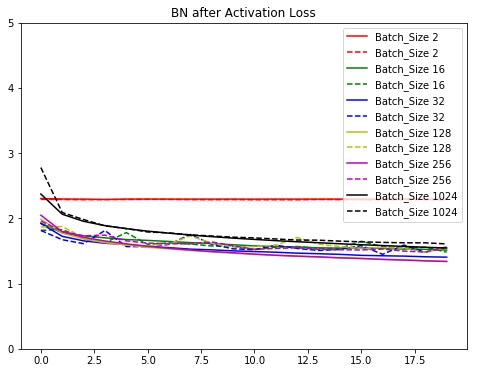

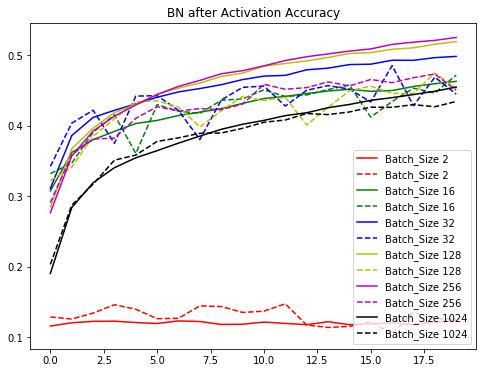

In [10]:
Draw_Result(results_3, 3)

In [11]:
# BN before Activation
results_2 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, output_units, num_neurons, 2, results_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
__________

50000/50000 [==============================] - 7s 136us/step - loss: 1.3888 - acc: 0.5079 - val_loss: 1.4026 - val_acc: 0.4925
Epoch 14/20
50000/50000 [==============================] - 7s 139us/step - loss: 1.3734 - acc: 0.5118 - val_loss: 1.4096 - val_acc: 0.4998
Epoch 15/20
50000/50000 [==============================] - 7s 141us/step - loss: 1.3629 - acc: 0.5162 - val_loss: 1.3906 - val_acc: 0.5066
Epoch 16/20
50000/50000 [==============================] - 7s 140us/step - loss: 1.3531 - acc: 0.5213 - val_loss: 1.3866 - val_acc: 0.5032
Epoch 17/20
50000/50000 [==============================] - 7s 143us/step - loss: 1.3458 - acc: 0.5222 - val_loss: 1.4596 - val_acc: 0.4753
Epoch 18/20
50000/50000 [==============================] - 7s 144us/step - loss: 1.3419 - acc: 0.5234 - val_loss: 1.4630 - val_acc: 0.4796
Epoch 19/20
50000/50000 [==============================] - 7s 142us/step - loss: 1.3313 - acc: 0.5258 - val_loss: 1.4278 - val_acc: 0.4902
Epoch 20/20
50000/50000 [==============

Epoch 6/20
50000/50000 [==============================] - 3s 55us/step - loss: 1.4343 - acc: 0.4923 - val_loss: 1.5623 - val_acc: 0.4481
Epoch 7/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.4011 - acc: 0.5026 - val_loss: 1.6589 - val_acc: 0.4159
Epoch 8/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.3705 - acc: 0.5132 - val_loss: 1.5920 - val_acc: 0.4290
Epoch 9/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.3448 - acc: 0.5221 - val_loss: 1.5668 - val_acc: 0.4466
Epoch 10/20
50000/50000 [==============================] - 3s 55us/step - loss: 1.3229 - acc: 0.5294 - val_loss: 1.5279 - val_acc: 0.4601
Epoch 11/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.2999 - acc: 0.5394 - val_loss: 1.5231 - val_acc: 0.4624
Epoch 12/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.2811 - acc: 0.5445 - val_loss: 1.5537 - val_acc: 0.4510
Epoch 13/20
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 3s 66us/step - loss: 2.2639 - acc: 0.1812 - val_loss: 2.3252 - val_acc: 0.1729
Epoch 2/20
50000/50000 [==============================] - 2s 35us/step - loss: 2.0840 - acc: 0.2701 - val_loss: 2.0661 - val_acc: 0.2752
Epoch 3/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.9920 - acc: 0.3054 - val_loss: 1.9705 - val_acc: 0.3072
Epoch 4/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.9238 - acc: 0.3297 - val_loss: 1.9180 - val_acc: 0.3283
Epoch 5/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.8688 - acc: 0.3506 - val_loss: 1.8660 - val_acc: 0.3456
Epoch 6/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.8226 - acc: 0.3662 - val_loss: 1.8256 - val_acc: 0.3602
Epoch 7/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.7821 - acc: 0.3805 - val_loss: 1.8026 - val_acc

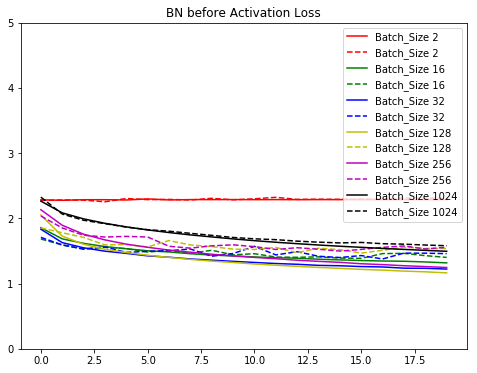

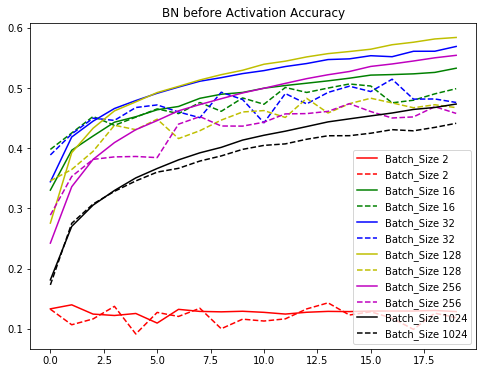

In [12]:
Draw_Result(results_2, 2)

In [23]:
# BN after Input Layer
results_1 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, output_units, num_neurons, 1, results_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
dense_50 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 16)                528       
__________

50000/50000 [==============================] - 9s 181us/step - loss: 1.3136 - acc: 0.5290 - val_loss: 1.4172 - val_acc: 0.4956
Epoch 18/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.3115 - acc: 0.5331 - val_loss: 1.4091 - val_acc: 0.4992
Epoch 19/20
50000/50000 [==============================] - 9s 182us/step - loss: 1.2958 - acc: 0.5359 - val_loss: 1.4083 - val_acc: 0.4996
Epoch 20/20
50000/50000 [==============================] - 9s 180us/step - loss: 1.2965 - acc: 0.5417 - val_loss: 1.3962 - val_acc: 0.5021
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                19667

50000/50000 [==============================] - 4s 77us/step - loss: 1.2812 - acc: 0.5439 - val_loss: 1.4308 - val_acc: 0.4971
Epoch 14/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.2643 - acc: 0.5479 - val_loss: 1.4280 - val_acc: 0.4969
Epoch 15/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.2483 - acc: 0.5541 - val_loss: 1.4250 - val_acc: 0.4973
Epoch 16/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.2334 - acc: 0.5590 - val_loss: 1.4294 - val_acc: 0.5013
Epoch 17/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.2195 - acc: 0.5614 - val_loss: 1.4244 - val_acc: 0.5080
Epoch 18/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.2035 - acc: 0.5692 - val_loss: 1.4240 - val_acc: 0.4977
Epoch 19/20
50000/50000 [==============================] - 4s 78us/step - loss: 1.1934 - acc: 0.5729 - val_loss: 1.4400 - val_acc: 0.5007
Epoch 20/20
50000/50000 [=====================

Epoch 10/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6927 - acc: 0.3900 - val_loss: 1.6958 - val_acc: 0.3890
Epoch 11/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6727 - acc: 0.3981 - val_loss: 1.6780 - val_acc: 0.3972
Epoch 12/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6538 - acc: 0.4052 - val_loss: 1.6625 - val_acc: 0.4019
Epoch 13/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6354 - acc: 0.4145 - val_loss: 1.6481 - val_acc: 0.4073
Epoch 14/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6183 - acc: 0.4193 - val_loss: 1.6346 - val_acc: 0.4101
Epoch 15/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.6017 - acc: 0.4261 - val_loss: 1.6222 - val_acc: 0.4166
Epoch 16/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.5861 - acc: 0.4315 - val_loss: 1.6102 - val_acc: 0.4203
Epoch 17/20
50000/50000 [=========

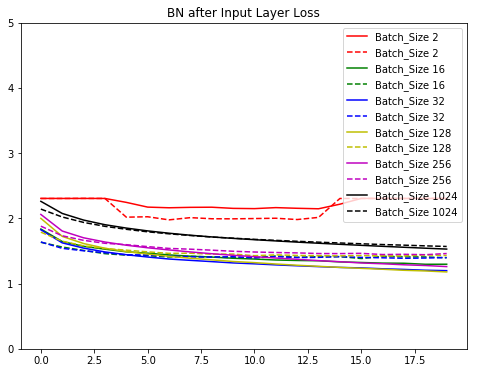

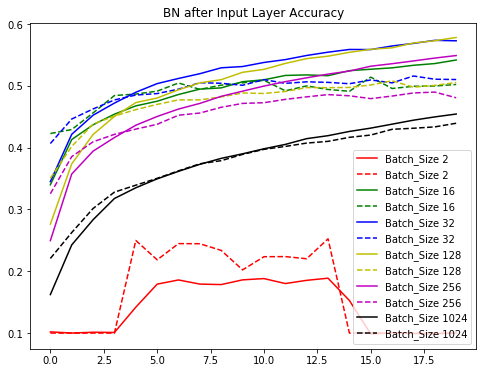

In [24]:
Draw_Result(results_1, 1)

In [25]:
# No BN layer
results_0 = {}
Training_Model(LEARNING_RATE, EPOCHS, BATCH_SIZE, MOMENTUM, output_units, num_neurons, 0, results_0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 16)                528       
_________________________________________________________________
dense_69 (Dense)             (None, 16)                272       
__________

50000/50000 [==============================] - 8s 161us/step - loss: 1.3198 - acc: 0.5265 - val_loss: 1.4025 - val_acc: 0.4998
Epoch 20/20
50000/50000 [==============================] - 8s 163us/step - loss: 1.3124 - acc: 0.5304 - val_loss: 1.4192 - val_acc: 0.4876
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
dense_73 (Dense)             (None, 64)                4160      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2080      
_________________________________________________________________
dense_74 (Dense)             (None, 32)                1056      
________

50000/50000 [==============================] - 3s 57us/step - loss: 1.3727 - acc: 0.5080 - val_loss: 1.4606 - val_acc: 0.4799
Epoch 18/20
50000/50000 [==============================] - 3s 67us/step - loss: 1.3616 - acc: 0.5131 - val_loss: 1.4567 - val_acc: 0.4765
Epoch 19/20
50000/50000 [==============================] - 3s 63us/step - loss: 1.3539 - acc: 0.5134 - val_loss: 1.4533 - val_acc: 0.4802
Epoch 20/20
50000/50000 [==============================] - 3s 56us/step - loss: 1.3375 - acc: 0.5218 - val_loss: 1.4427 - val_acc: 0.4837
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                196672    
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160     

50000/50000 [==============================] - 2s 34us/step - loss: 1.7602 - acc: 0.3685 - val_loss: 1.7503 - val_acc: 0.3719
Epoch 16/20
50000/50000 [==============================] - 2s 34us/step - loss: 1.7468 - acc: 0.3726 - val_loss: 1.7373 - val_acc: 0.3766
Epoch 17/20
50000/50000 [==============================] - 2s 34us/step - loss: 1.7339 - acc: 0.3768 - val_loss: 1.7244 - val_acc: 0.3801
Epoch 18/20
50000/50000 [==============================] - 2s 34us/step - loss: 1.7206 - acc: 0.3836 - val_loss: 1.7134 - val_acc: 0.3857
Epoch 19/20
50000/50000 [==============================] - 2s 34us/step - loss: 1.7086 - acc: 0.3857 - val_loss: 1.7003 - val_acc: 0.3898
Epoch 20/20
50000/50000 [==============================] - 2s 35us/step - loss: 1.6960 - acc: 0.3922 - val_loss: 1.6896 - val_acc: 0.3920


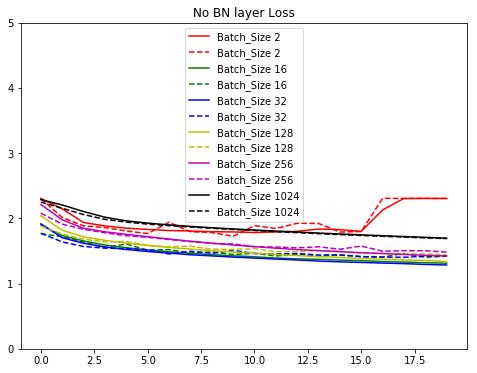

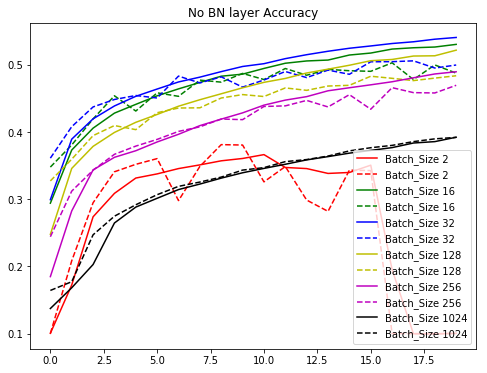

In [26]:
Draw_Result(results_0, 0)